## 本节内容
- numpy实现MLP

## 一、神经网络结构

神经网络的一般结构是由输入层、隐藏层(神经元)、输出层构成的。隐藏层可以是1层或者多层叠加，层与层之间是相互连接的，如下图所示：

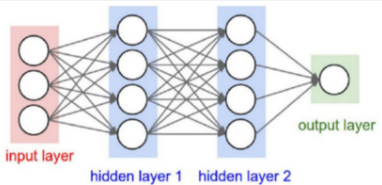

本节简化一下，现在MLP只有三层：输入层、一层隐藏层、输出层：

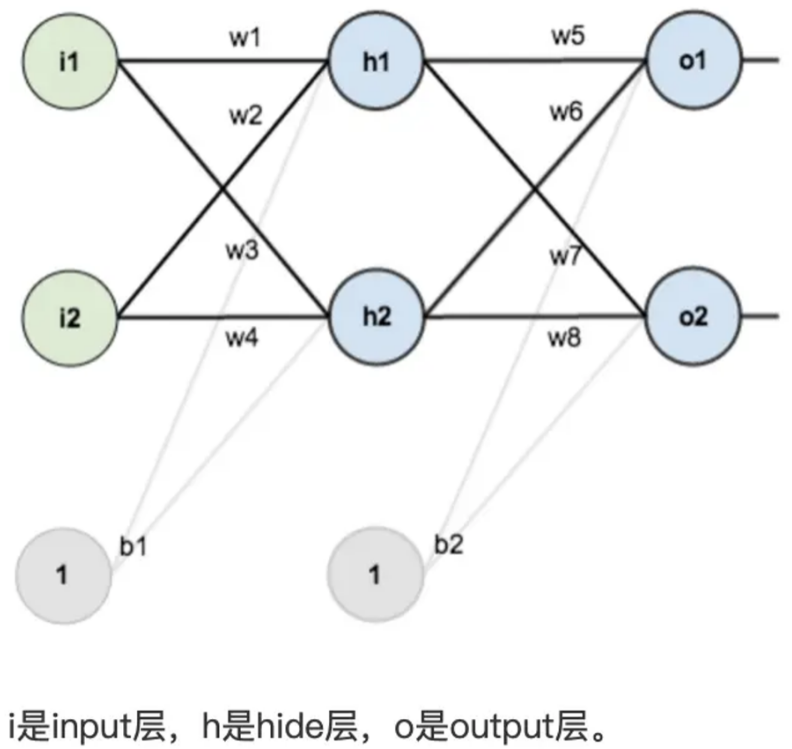

### 1、神经元

神经元一般常用sigmoid函数，具有激活功能

In [4]:
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# derivative of sigmoid
# sigmoid(y) * (1.0 - sigmoid(y))
# the way we use this y is already sigmoided
def dsigmoid(y):
    return y * (1.0 - y)

### 2、神经网络初始化参数

- 隐藏层参数
- 输出层参数
- 输入层参数

In [ ]:
class MLP_NeuralNetwork(object):
    def __init__(self, input, hidden, output):
        """
        :param input: number of input neurons
        :param hidden: number of hidden neurons
        :param output: number of output neurons
        """
        self.input = input + 1 # add 1 for bias node
        self.hidden = hidden
        self.output = output
        # set up array of 1s for activations
        self.ai = [1.0] * self.input
        self.ah = [1.0] * self.hidden
        self.ao = [1.0] * self.output
        # create randomized weights
        self.wi = np.random.randn(self.input, self.hidden) 
        self.wo = np.random.randn(self.hidden, self.output) 
        # create arrays of 0 for changes
        self.ci = np.zeros((self.input, self.hidden))
        self.co = np.zeros((self.hidden, self.output))

一般用矩阵做所有这些计算，因为它们速度快，而且非常容易阅读，

输入层的大小(特性)、隐藏层的大小(要调优的变量参数)和输出层的数量(可能的类的数量)

> 注意：我们将所有的权重初始化为随机数。重要的是权值是随机的，否则我们将无法调整网络。如果所有的权重是一样的，那么所有隐藏的单位都是一样的，那你的神经网络算法就废了
>

### 3、前馈网络
第一层计算：

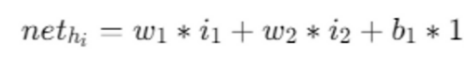

第一层激活函数：

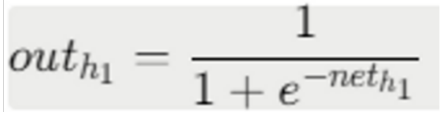


第二层计算（output）:

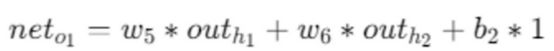

第二层激活函数：

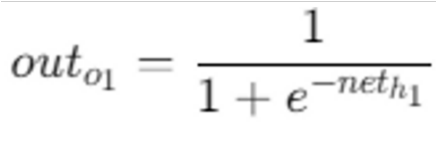


In [ ]:
def feedForward(self, inputs):
    if len(inputs) != self.input-1:
        raise ValueError('Wrong number of inputs you silly goose!')
    # input activations
    for i in range(self.input -1): # -1 is to avoid the bias
        self.ai[i] = inputs[i]
    # hidden activations
    for j in range(self.hidden):
        sum = 0.0
        for i in range(self.input):
            sum += self.ai[i] * self.wi[i][j]
        self.ah[j] = sigmoid(sum)
    # output activations
    for k in range(self.output):
        sum = 0.0
        for j in range(self.hidden):
            sum += self.ah[j] * self.wo[j][k]
        self.ao[k] = sigmoid(sum)
    return self.ao[:]

### 4、反向传播（重要）

参考：https://www.aiexplorer.blog/article/bp.html

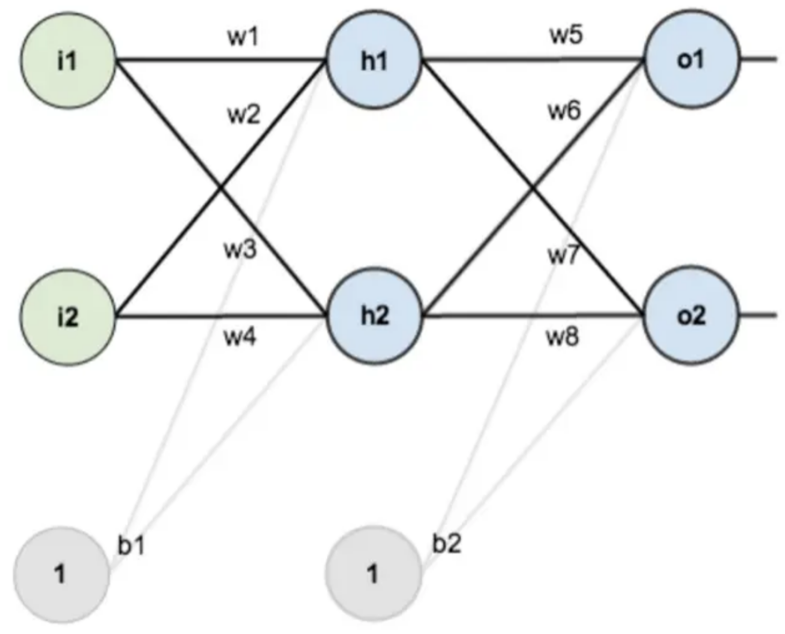

4.1、统计误差

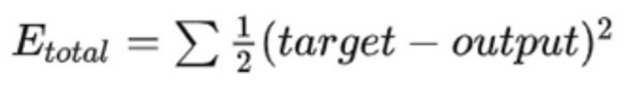

4.2、反向传播

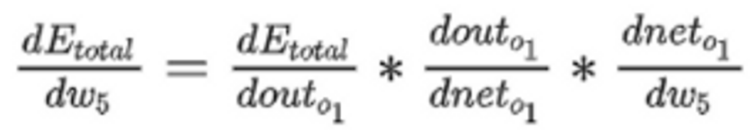

其实如下图所示，输出层BP：

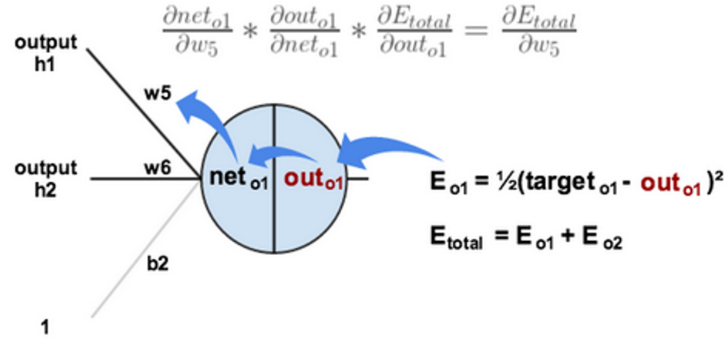

隐藏层BP：

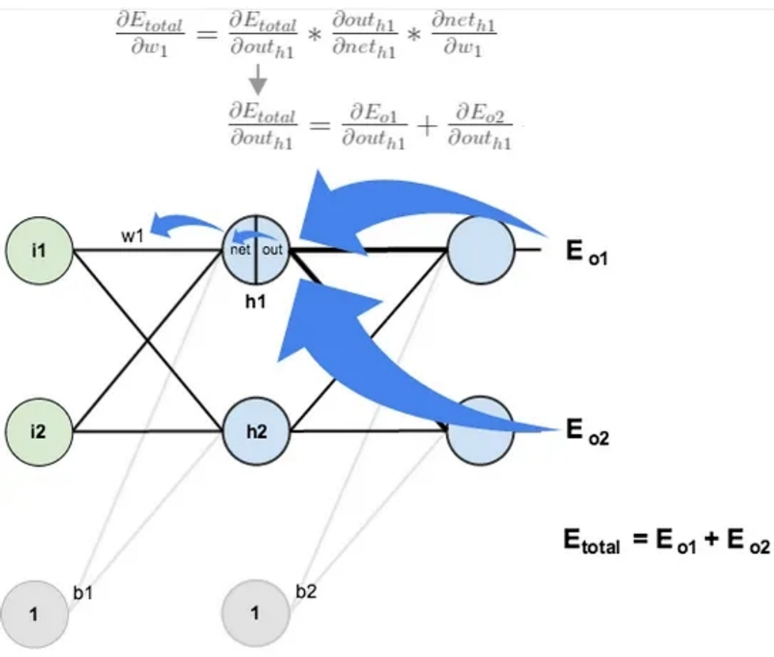


In [ ]:

def backPropagate(self, targets, N):
    """
    :param targets: y values
    :param N: learning rate
    :return: updated weights and current error
    """
    if len(targets) != self.output:
        raise ValueError('Wrong number of targets you silly goose!')
    # calculate error terms for output
    # the delta tell you which direction to change the weights
    # 计算输出层的梯度
    output_deltas = [0.0] * self.output
    for k in range(self.output):
        error = -(targets[k] - self.ao[k])
        output_deltas[k] = dsigmoid(self.ao[k]) * error
    # calculate error terms for hidden
    # delta tells you which direction to change the weights
    # 计算隐藏层的梯度
    hidden_deltas = [0.0] * self.hidden
    for j in range(self.hidden):
        error = 0.0
        for k in range(self.output):
            error += output_deltas[k] * self.wo[j][k]
        hidden_deltas[j] = dsigmoid(self.ah[j]) * error
    # update the weights connecting hidden to output
    # 更新输出层参数
    for j in range(self.hidden):
        for k in range(self.output):
            change = output_deltas[k] * self.ah[j]
            self.wo[j][k] -= N * change + self.co[j][k]
            self.co[j][k] = change
    # update the weights connecting input to hidden
    # 更新隐藏层参数
    for i in range(self.input):
        for j in range(self.hidden):
            change = hidden_deltas[j] * self.ai[i]
            self.wi[i][j] -= N * change + self.ci[i][j]
            self.ci[i][j] = change
    # calculate error loss funciton
    # 计算损失函数
    error = 0.0
    for k in range(len(targets)):
        error += 0.5 * (targets[k] - self.ao[k]) ** 2
    return error

### 6、推理（predict)

- 调用feedforward

In [ ]:
def predict(self, X):
    """
    return list of predictions after training algorithm
    """
    predictions = []
    for p in X:
        predictions.append(self.feedForward(p))
    return predictions

## 二、MLP代码

In [1]:
import time
import math
import random
import numpy as np

class MLP_NeuralNetwork(object):
    def __init__(self, input, hidden, output,iterations, learning_rate, momentum, rate_decay):
        """
        :param input: number of input neurons
        :param hidden: number of hidden neurons
        :param output: number of output neurons
        """
        # initialize parameters
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        
        
        self.input = input + 1 # add 1 for bias node
        self.hidden = hidden
        self.output = output
        # set up array of 1s for activations
        self.ai = [1.0] * self.input
        self.ah = [1.0] * self.hidden
        self.ao = [1.0] * self.output
        # create randomized weights
        # use scheme from 'efficient backprop to initialize weights
        input_range = 1.0 / self.input ** (1/2)
        output_range = 1.0 / self.hidden ** (1/2)
        self.wi = np.random.normal(loc = 0, scale = input_range, size = (self.input, self.hidden))
        self.wo = np.random.normal(loc = 0, scale = output_range, size = (self.hidden, self.output))
        # create arrays of 0 for changes
        self.ci = np.zeros((self.input, self.hidden))
        self.co = np.zeros((self.hidden, self.output))
	
    #前馈网络
    def feedForward(self, inputs):
        if len(inputs) != self.input-1:
                raise ValueError('Wrong number of inputs you silly goose!')
        # input activations
        for i in range(self.input -1): # -1 is to avoid the bias
            self.ai[i] = inputs[i]
        # hidden activations
        for j in range(self.hidden):
            sum = 0.0
            for i in range(self.input):
                sum += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum)
        # output activations
        for k in range(self.output):
            sum = 0.0
            for j in range(self.hidden):
                sum += self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)
        return self.ao[:]

    #反向传播
    def backPropagate(self, targets):
        """
        :param targets: y values
        :param N: learning rate
        :return: updated weights and current error
        """
        if len(targets) != self.output:
            raise ValueError('Wrong number of targets you silly goose!')
        # calculate error terms for output
        # the delta tell you which direction to change the weights
        output_deltas = [0.0] * self.output
        for k in range(self.output):
            error = -(targets[k] - self.ao[k])
            output_deltas[k] = dsigmoid(self.ao[k]) * error
        # calculate error terms for hidden
        # delta tells you which direction to change the weights
        hidden_deltas = [0.0] * self.hidden
        for j in range(self.hidden):
            error = 0.0
            for k in range(self.output):
                error += output_deltas[k] * self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error
        # update the weights connecting hidden to output
        for j in range(self.hidden):
            for k in range(self.output):
                change = output_deltas[k] * self.ah[j]
                self.wo[j][k] -= self.learning_rate * change + self.co[j][k]
                self.co[j][k] = change
        # update the weights connecting input to hidden
        for i in range(self.input):
            for j in range(self.hidden):
                change = hidden_deltas[j] * self.ai[i]
                self.wi[i][j] -= self.learning_rate * change + self.ci[i][j]
                self.ci[i][j] = change
        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5 * (targets[k] - self.ao[k]) ** 2
        return error
    
    #测试
    def test(self, patterns):
        """
        Currently this will print out the targets next to the predictions.
        Not useful for actual ML, just for visual inspection.
        """
        for p in patterns:
            print(p[1], '->', self.feedForward(p[0]))
    
    #训练
    def train(self, patterns):
        # N: learning rate
        for i in range(self.iterations):
            error = 0.0
            random.shuffle(patterns)
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.feedForward(inputs)
                error += self.backPropagate(targets)
            if i % 10 == 0:
                print("iterations:%d ,lr:%-.5f ,error:%-.5f " % (i,self.learning_rate,error))
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
            # if i % 10 == 0:
            #     print('error %-.5f' % error)
            # learning rate decay
            self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))

    #预测
    def predict(self, X):
        """
        return list of predictions after training algorithm
        """
        predictions = []
        for p in X:
            predictions.append(self.feedForward(p))
        return predictions



    


In [5]:

def demo():
    """
    run NN demo on the digit recognition dataset from sklearn
    """
    def load_data():
        data = np.loadtxt('data/sklearn_digits.csv', delimiter = ',')

        # first ten values are the one hot encoded y (target) values
        y = data[:,0:10] # 0-9 之间的数字
        
        data = data[:,10:] # x data
        data -= data.min() # scale the data so values are between 0 and 1
        data /= data.max() # scale
        
        out = []
        #print data.shape

        # populate the tuple list with the data
        for i in range(data.shape[0]):
            tupledata = list((data[i,:].tolist(), y[i].tolist())) # don't mind this variable name
            out.append(tupledata)

        return out
    
    start = time.time()
    
    X = load_data()

    #print X[9] # make sure the data looks right

    NN = MLP_NeuralNetwork(64, 100, 10, iterations = 50, learning_rate = 0.5, momentum = 0.5, rate_decay = 0.01)

    NN.train(X)
    
    NN.test(X)
    
    end = time.time()
    print(end - start)

In [6]:
if __name__ == '__main__':
    demo()

iterations:0 ,lr:0.50000 ,error:390.23292 
iterations:10 ,lr:0.45264 ,error:17.90928 
iterations:20 ,lr:0.40977 ,error:3.94155 
iterations:30 ,lr:0.37096 ,error:3.35150 
iterations:40 ,lr:0.33583 ,error:2.82140 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] -> [9.954149546359596e-07, 0.0038266754352287166, 5.945693095972867e-05, 0.00022352950209246773, 0.00027619458070618117, 1.7242835287614247e-07, 0.004715907934525321, 2.5607108149545702e-05, 0.999677455227959, 4.99950293504657e-07]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] -> [3.4484846895825574e-06, 0.9978170398732685, 0.00015710025977808841, 5.410727845704331e-08, 0.0009810456952887671, 1.1571761761795119e-05, 0.0016681416055614679, 1.3686769968797855e-05, 0.002159577424363536, 2.636545080759063e-08]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] -> [0.9984509481146195, 3.694765700189599e-12, 4.832316145894332e-07, 9.225304918033503e-06, 5.679243681251751e-07, 4.1711778933278895e-05, 8.307533381168384e-08, 0.0012